### Let us Import all the libraries


In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import requests # to send requesto url
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if firt time 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
#from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if first time
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py36_0         147 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2019.9.11  |       hecc5488_0         144 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    cer

### let us define function to rename detaframe colums

In [3]:
#define function to rename colunms 
def RenameDfColums(df, cList, start):
    iteration = len(cList)
    
    if (start+ iteration) > df.shape[1]:
        iteration = df.shape[1] - start 
    #print("Number of iteration",iteration, )
    
    Temp_df = df
    Temp_df.head()
    i = 0
    while i < iteration: 
        #print(i) 
        Temp_df.rename(columns={Temp_df.columns[start+i]:cList[i]},inplace = True) 
        i=i+1
        
    return (Temp_df)

###  let us creat url for DFW zip code/city data  and Request the server to connect

In [4]:
#create url
url = 'https://www.zip-codes.com/state/tx.asp'

#Request web server to connect
Dallas_url = requests.get(url)
Dallas_url

<Response [200]>

###  Read text from the url with read_html and find table with useful data

In [5]:
#Read_html
DFW_data = pd.read_html(Dallas_url.text,header =0)

In [6]:
#check how many tables are in the html
print('There are {} tables type of {}'.format(len(DFW_data), type(DFW_data)))

There are 4 tables type of <class 'list'>


###  Take the table with zip code information 

In [7]:
Dfw_df = DFW_data[2]
Dfw_df.head()

,ZIP Code,City,County,Type
0,ZIP Code 73301,Austin,Travis,Unique
1,ZIP Code 73344,Austin,Travis,Unique
2,ZIP Code 73960,Texhoma,Sherman,P.O. Box
3,ZIP Code 75001,Addison,Dallas,Standard
4,ZIP Code 75002,Allen,Collin,Standard


###  Drop "Type" column and rename "ZIP  Code" (ZipCode)

In [8]:
Dfw_df.drop(['Type'],axis=1, inplace=True)
RenameDfColums(Dfw_df, ['ZipCode','City','County'], 0)
Dfw_df.head()

,ZipCode,City,County
0,ZIP Code 73301,Austin,Travis
1,ZIP Code 73344,Austin,Travis
2,ZIP Code 73960,Texhoma,Sherman
3,ZIP Code 75001,Addison,Dallas
4,ZIP Code 75002,Allen,Collin


In [9]:
#create url for dfw population data
url = 'https://en.wikipedia.org/wiki/Dallas%E2%80%93Fort_Worth_metroplex'

#Request web server to connect
Dfw_url = requests.get(url)
DFW_pop = pd.read_html(Dfw_url.text,header =0)
#check how many tables are in the html
print('There are {} tables type of {}'.format(len(DFW_pop), type(DFW_pop)))

There are 22 tables type of <class 'list'>


In [10]:
Dfw_pop = DFW_pop[5]
Dfw_pop = Dfw_pop[['County', '2017 Estimate', '2010 Census']]
Dfw_pop.head()

,County,2017 Estimate,2010 Census
0,Collin County,969603,782341
1,Dallas County,2618148,2368139
2,Denton County,836210,662614
3,Ellis County,173620,149610
4,Hood County,58273,51182


In [11]:
Dfw_pop['Pop Change'] = ((100*(Dfw_pop['2017 Estimate'] - Dfw_pop['2010 Census'])/Dfw_pop['2010 Census'])).round(2).astype(str) + " %"
Dfw_pop.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,County,2017 Estimate,2010 Census,Pop Change
0,Collin County,969603,782341,23.94 %
1,Dallas County,2618148,2368139,10.56 %
2,Denton County,836210,662614,26.2 %
3,Ellis County,173620,149610,16.05 %
4,Hood County,58273,51182,13.85 %


In [12]:
#Sort data 
Dfw_pop=Dfw_pop.sort_values('2017 Estimate', ascending=False ).reset_index(drop=True)
Dfw_pop.head()

,County,2017 Estimate,2010 Census,Pop Change
0,Total,7399662,6426214,15.15 %
1,Dallas County,2618148,2368139,10.56 %
2,Tarrant County,2054475,1809034,13.57 %
3,Collin County,969603,782341,23.94 %
4,Denton County,836210,662614,26.2 %


###  Set county as index columns and plot horizontal bar graph to compare population growth 

In [13]:
dfwPop = Dfw_pop.set_index('County')
dfwPop.head()

,2017 Estimate,2010 Census,Pop Change
County,,,
Total,7399662,6426214,15.15 %
Dallas County,2618148,2368139,10.56 %
Tarrant County,2054475,1809034,13.57 %
Collin County,969603,782341,23.94 %
Denton County,836210,662614,26.2 %


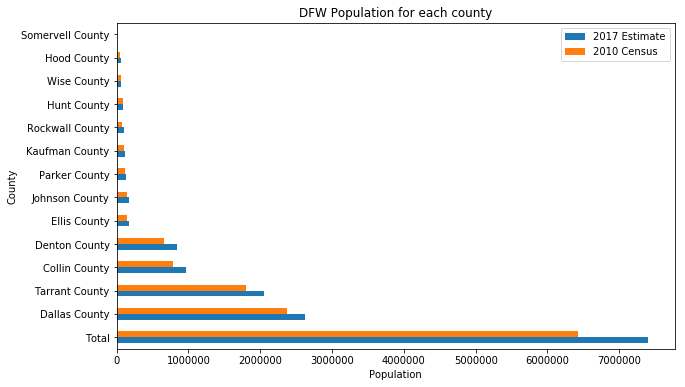

In [14]:
#plot
dfwPop.plot(kind='barh', figsize=(10, 6))
plt.ylabel('County') 
plt.xlabel('Population') 
plt.title('DFW Population for each county') 
plt.show()

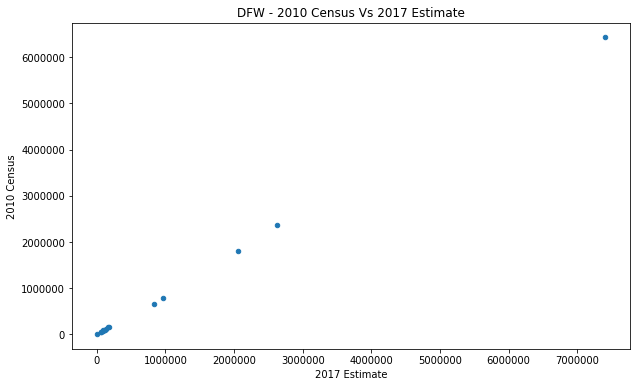

In [15]:
dfwPop.plot( x='2017 Estimate', y= '2010 Census', kind='scatter',figsize=(10, 6))
plt.xlabel('2017 Estimate') 
plt.ylabel('2010 Census') 
plt.title('DFW - 2010 Census Vs 2017 Estimate') 
plt.show()

###  From the Bard graph the most populated counties are Dallas, Tarrant, collin and Denton. I'll use only these counties for the analysis

In [16]:
Counties = ['Collin', 'Dallas', 'Denton', 'Tarrant']
print(Dfw_df.shape)
#Counties = ['Collin', 'Dallas', 'Denton', 'Ellis', 'Hood', 'Hunt', 'Johnson', 'Kaufman', 'Parker', 'Rockwall', 'Somervell', 'Tarrant','Wise']
#Counties = ['Dallas', 'Tarrant']
Dfw_df = Dfw_df[Dfw_df['County'].isin(Counties)].reset_index(drop=True)
Dfw_df.head()

(2598, 3)


,ZipCode,City,County
0,ZIP Code 75001,Addison,Dallas
1,ZIP Code 75002,Allen,Collin
2,ZIP Code 75006,Carrollton,Dallas
3,ZIP Code 75007,Carrollton,Denton
4,ZIP Code 75009,Celina,Collin


In [17]:
Dfw_df.shape

(324, 3)

###  Let us clean Zipcode values, keep only the Zipcode numbers

In [18]:
temp = pd.DataFrame(columns=['ZipCode'])

for list in Dfw_df['ZipCode']:
    temp['ZipCode']  = Dfw_df['ZipCode'].str.split().str[2]

Dfw_df['ZipCode'] = temp['ZipCode']
Dfw_df.head()

,ZipCode,City,County
0,75001,Addison,Dallas
1,75002,Allen,Collin
2,75006,Carrollton,Dallas
3,75007,Carrollton,Denton
4,75009,Celina,Collin


In [19]:
Dfw_df.shape

(324, 3)

###  Let us Import Zipcode Latitude and longitude values 

In [69]:
# The code was removed by Watson Studio for sharing.

,Zip,City,State,Latitude,Longitude
0,71937,Cove,AR,34.398483,-94.39398
1,72044,Edgemont,AR,35.624351,-92.16056
2,56171,Sherburn,MN,43.660847,-94.74357
3,49430,Lamont,MI,43.010337,-85.89754
4,52585,Richland,IA,41.194129,-91.98027


###  Let us drop some of additional columns which are not relevant. Also, take zip codes for DFW area only (75001-76670)

In [70]:
# Creat Dfw_Zipcode dataframe which covers zipcodes only in DFW(75001 to 76670)
Dfw_ZipCode = ZipCode_df.loc[(ZipCode_df['Zip'] >= 75001) & (ZipCode_df['Zip'] <= 76670)].reset_index(drop=True)

Dfw_ZipCode.drop(['City','State'],axis=1, inplace=True)
Dfw_ZipCode.head()

,Zip,Latitude,Longitude
0,75475,33.485315,-96.25525
1,75757,32.136787,-95.36710
2,75010,33.030556,-96.89328
3,76054,32.858398,-97.17681
4,75961,31.626011,-94.60338


In [71]:
Dfw_ZipCode.shape

(946, 3)

###  Rename Zip to ZipCode

In [72]:
RenameDfColums(Dfw_ZipCode, ['ZipCode'], 0)
Dfw_ZipCode.head()

,ZipCode,Latitude,Longitude
0,75475,33.485315,-96.25525
1,75757,32.136787,-95.36710
2,75010,33.030556,-96.89328
3,76054,32.858398,-97.17681
4,75961,31.626011,-94.60338


In [73]:
Dfw_ZipCode.shape

(946, 3)

###  Check data type for each dataframes before merging them

In [74]:
print(Dfw_ZipCode.dtypes)
print(Dfw_df.dtypes)

ZipCode        int64
Latitude     float64
Longitude    float64
dtype: object
ZipCode     int64
City       object
County     object
dtype: object


Let Us change Zipcode data type int64

In [75]:
Dfw_df['ZipCode'] = Dfw_df['ZipCode'].astype(int)
print(Dfw_df.dtypes)

ZipCode     int64
City       object
County     object
dtype: object


###  Inner joint the two dataframes and create Dfw_data 

In [76]:
#Dfw_data = pd.merge(Dfw_df, Dfw_ZipCode, on='ZipCode',how='inner')
Dfw_data = pd.merge(Dfw_df, Dfw_ZipCode, on='ZipCode')
Dfw_data.head()

,ZipCode,City,County,Latitude,Longitude
0,75001,Addison,Dallas,32.961290,-96.83751
1,75002,Allen,Collin,33.092846,-96.62447
2,75006,Carrollton,Dallas,32.960374,-96.89163
3,75007,Carrollton,Denton,33.005420,-96.89773
4,75009,Celina,Collin,33.327927,-96.76129


In [77]:
print (Dfw_data.shape)
print (Dfw_df.shape)
print (Dfw_ZipCode.shape)

(317, 5)
(324, 3)
(946, 3)


In [29]:
Dfw_data['City'] = Dfw_data['City'] + "_" + Dfw_data['ZipCode'].apply(str)
Dfw_data.head()

,ZipCode,City,County,Latitude,Longitude
0,75001,Addison_75001,Dallas,32.961290,-96.83751
1,75002,Allen_75002,Collin,33.092846,-96.62447
2,75006,Carrollton_75006,Dallas,32.960374,-96.89163
3,75007,Carrollton_75007,Denton,33.005420,-96.89773
4,75009,Celina_75009,Collin,33.327927,-96.76129


In [78]:
Dfw_data.dtypes

ZipCode        int64
City          object
County        object
Latitude     float64
Longitude    float64
dtype: object

In [79]:
Dfw_data['ZipCode'] = Dfw_data['ZipCode'].astype(object)
print(Dfw_data.dtypes)

ZipCode       object
City          object
County        object
Latitude     float64
Longitude    float64
dtype: object


### Let us explore Dallas, TX 

In [80]:
address = 'Dallas, TX'

geolocator = Nominatim(user_agent="Dallas_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of dallas are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of dallas are 32.7762719, -96.7968559.


In [81]:
#create map of Dallas using latitude and longitude values
map_Dfw = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, City, ZipCode in zip(Dfw_data['Latitude'], Dfw_data['Longitude'], Dfw_data['City'], Dfw_data['ZipCode']):
    label = '{}, {}'.format(City, ZipCode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(map_Dfw)  
    
map_Dfw

In [82]:
Dfw_data.loc[0, 'City']

'Addison'

In [83]:
City_latitude = Dfw_data.loc[0, 'Latitude'] # City latitude value
City_longitude = Dfw_data.loc[0, 'Longitude'] # City longitude value

City_name = Dfw_data.loc[0, 'City'] # neighborhCityood name

print('Latitude and longitude values of {} are {}, {}.'.format(City_name, 
                                                               City_latitude, 
                                                               City_longitude))

Latitude and longitude values of Addison are 32.961290000000005, -96.83751.


In [84]:
# The code was removed by Watson Studio for sharing.

In [85]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5dd1970d618f43001be8355e'},
 'response': {'headerLocation': 'Dallas',
  'headerFullLocation': 'Dallas',
  'headerLocationGranularity': 'city',
  'totalResults': 6,
  'suggestedBounds': {'ne': {'lat': 32.96579000450001,
    'lng': -96.83215672561215},
   'sw': {'lat': 32.9567899955, 'lng': -96.84286327438784}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4afd9354f964a520bb2822e3',
       'name': "Cindi's N.Y. Delicatessen",
       'location': {'address': '2001 Midway Rd Ste 132',
        'crossStreet': 'btwn Midcourt Rd. & Wiley Post Rd.',
        'lat': 32.96186353703873,
        'lng': -96.83887266048376,
        'labeledLatLngs': [{'label': 'display',
          'lat': 32.96186353703873,
          'lng': -96.83887266048376}],
   

In [86]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [87]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Cindi's N.Y. Delicatessen,Diner,32.961864,-96.838873
1,La Spiga,Bakery,32.958278,-96.837417
2,Enterprise Rent-A-Car,Rental Car Location,32.960673,-96.838102
3,Dallas Desk,Furniture / Home Store,32.957869,-96.838840
4,Five Star Fabric,Arts & Crafts Store,32.959985,-96.838228


In [88]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

6 venues were returned by Foursquare.


In [89]:

def getNearbyVenues(names, latitudes, longitudes, radius=250):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [90]:
Dfw_venues_raw = getNearbyVenues(names=Dfw_data['City'],
                                   latitudes=Dfw_data['Latitude'],
                                   longitudes=Dfw_data['Longitude']
                                  )

Addison
Allen
Carrollton
Carrollton
Celina
Carrollton
Carrollton
Allen
Irving
Irving
Irving
Irving
Coppell
Flower Mound
Plano
Plano
Plano
Plano
Flower Mound
Flower Mound
Lewisville
Rowlett
Frisco
Frisco
Irving
Irving
Garland
Garland
Garland
Garland
Garland
Garland
Garland
Garland
Sachse
Garland
Grand Prairie
Grand Prairie
Grand Prairie
Grand Prairie
Grand Prairie
The Colony
Lewisville
Irving
Irving
Irving
Irving
Irving
Lake Dallas
Lewisville
Little Elm
Mckinney
Mckinney
Mckinney
Plano
Plano
Lewisville
Prosper
Richardson
Richardson
Richardson
Richardson
Richardson
Plano
Rowlett
Rowlett
Plano
Plano
Weston
Wylie
Coppell
Cedar Hill
Cedar Hill
Desoto
Duncanville
Copeville
Desoto
Lancaster
Duncanville
Duncanville
Hutchins
Lancaster
Mesquite
Mesquite
Seagoville
Josephine
Lavon
Wilmer
Nevada
Balch Springs
Mesquite
Sunnyvale
Mesquite
Mesquite
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas
Dallas


In [91]:
print(Dfw_venues_raw.shape)
Dfw_venues_raw.head()

(547, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Addison,32.96129,-96.83751,Cindi's N.Y. Delicatessen,32.961864,-96.838873,Diner
1,Addison,32.96129,-96.83751,Enterprise Rent-A-Car,32.960673,-96.838102,Rental Car Location
2,Addison,32.96129,-96.83751,Skyline Trapeze,32.961506,-96.837273,Athletics & Sports
3,Addison,32.96129,-96.83751,Scanning Nations,32.961567,-96.839008,Business Service
4,Addison,32.96129,-96.83751,Septien Entertainment Group,32.962329,-96.839551,Performing Arts Venue


In [93]:
Dfw_venues_raw.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Addison,5,5,5,5,5,5
Arlington,51,51,51,51,51,51
Balch Springs,5,5,5,5,5,5
Bedford,6,6,6,6,6,6
Carrollton,3,3,3,3,3,3
Cedar Hill,4,4,4,4,4,4
Colleyville,2,2,2,2,2,2
Copeville,1,1,1,1,1,1
Coppell,8,8,8,8,8,8


Let us use Zipcode with venues 5 or higher

In [116]:
Dfw_venues = Dfw_venues_raw.groupby('City').filter(lambda x : len(x)>9)
Dfw_venues.groupby('City').count()

,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Arlington,51,51,51,51,51,51
Dallas,226,226,226,226,226,226
Fort Worth,93,93,93,93,93,93
Grapevine,11,11,11,11,11,11
Irving,20,20,20,20,20,20
Plano,25,25,25,25,25,25
Roanoke,10,10,10,10,10,10


In [117]:
Dfw_venues.shape

(436, 7)

###  Let us create one hot encoder object

In [118]:
# one hot encoding
Dfw_onehot = pd.get_dummies(Dfw_venues[['Venue Category']], prefix="", prefix_sep="")

# add City column back to dataframe
Dfw_onehot['City'] = Dfw_venues['City'] 

# move City column to the first column
cls = Dfw_onehot.columns[:-1]
cls = cls.tolist()

fixed_columns = [Dfw_onehot.columns[-1]] + cls
Dfw_onehot = Dfw_onehot[fixed_columns]

Dfw_onehot.head()

,City,Adult Boutique,American Restaurant,Antique Shop,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beer Bar,Beer Garden,Big Box Store,Boutique,Breakfast Spot,Brewery,Burger Joint,Business Service,Café,Cajun / Creole Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Donut Shop,Electronics Store,Entertainment Service,Farm,Fast Food Restaurant,Flower Shop,Fondue Restaurant,Food,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Historic Site,Home Service,Hotel,Hotel Pool,Housing Development,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Latin American Restaurant,Lawyer,Liquor Store,Locksmith,Lounge,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Pool,Public Art,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shop & Service,Shopping Plaza,Smoke Shop,Smoothie Shop,Spa,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Weight Loss Center,Wings Joint,Women's Store
9,Plano,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23,Irving,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
24,Irving,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,Irving,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26,Irving,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [119]:
Dfw_onehot.shape

(436, 140)

###  Group venues by city

In [120]:
Dfw_grouped = Dfw_onehot.groupby('City').mean().reset_index()
Dfw_grouped

,City,Adult Boutique,American Restaurant,Antique Shop,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auto Garage,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beer Bar,Beer Garden,Big Box Store,Boutique,Breakfast Spot,Brewery,Burger Joint,Business Service,Café,Cajun / Creole Restaurant,Chinese Restaurant,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Donut Shop,Electronics Store,Entertainment Service,Farm,Fast Food Restaurant,Flower Shop,Fondue Restaurant,Food,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,Gift Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Historic Site,Home Service,Hotel,Hotel Pool,Housing Development,Ice Cream Shop,Indian Restaurant,Insurance Office,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Latin American Restaurant,Lawyer,Liquor Store,Locksmith,Lounge,Martial Arts Dojo,Mediterranean Restaurant,Mexican Restaurant,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Optical Shop,Organic Grocery,Other Repair Shop,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pawn Shop,Performing Arts Venue,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Pool,Public Art,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shipping Store,Shop & Service,Shopping Plaza,Smoke Shop,Smoothie Shop,Spa,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Volleyball Court,Weight Loss Center,Wings Joint,Women's Store
0,Arlington,0.000000,0.000000,0.000000,0.019608,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.019608,0.058824,0.019608,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.058824,0.000000,0.019608,0.000000,0.019608,0.000000,0.000000,0.039216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.00,0.00000,0.000000,0.00,0.078431,0.039216,0.000000,0.019608,0.000000,0.019608,0.000000,0.00,0.00,0.039216,0.019608,0.000000,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.00,0.039216,0.019608,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.00000,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.000000,0.039216,0.000000,0.039216,0.00,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.039216,0.019608,0.000000,0.000000,0.00,0.019608,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.019608,0.000000,0.000000,0.019608,0.000000,0.000000,0.000000,0.000000,0.019608,0.000000,0.000000
1,Dallas,0.004425,0.008850,0.013274,0.000000,0.00885,0.013274,0.004425,0.004425,0.008850,0.008850,0.008850,0.026549,0.004425,0.000000,0.004425,0.000000,0.000000,0.004425,0.004425,0.008850,0.004425,0.017699,0.004425,0.000000,0.004425,0.013274,0.013274,0.035398,0.000000,0.0,0.004425,0.004425,0.039823,0.004425,0.004425,0.004425,0.013274,0.004425,0.008850,0.000000,0.000000,0.017699,0.004425,0.004425,0.000000,0.026549,0.004425,0.000000,0.004425,0.008850,0.013274,0.026549,0.004425,0.000000,0.004425,0.013274,0.00,0.00885,0.004425,0.00,0.000000,0.022124,0.008850,0.000000,0.004425,0.022124,0.022124,0.00,0.00,0.000000,0.000000,0.008850,0.022124,0.004425,0.004425,0.000000,0.004425,0.004425,0.004425,0.004425,0.013274,0.008850,0.00,0.000000,0.048673,0.004425,0.004425,0.00000

In [121]:
Dfw_grouped.shape

(7, 140)

###   Let us check top 5 venues for each city

In [122]:
num_top_venues = 5

for hood in Dfw_grouped['City']:
    print("----"+hood+"----")
    temp = Dfw_grouped[Dfw_grouped['City'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Arlington----
               venue  freq
0      Grocery Store  0.08
1     Baseball Field  0.06
2  Convenience Store  0.06
3     Discount Store  0.06
4                Gym  0.04


----Dallas----
                  venue  freq
0    Mexican Restaurant  0.05
1        Sandwich Place  0.04
2     Convenience Store  0.04
3           Coffee Shop  0.04
4  Fast Food Restaurant  0.03


----Fort Worth----
                  venue  freq
0   American Restaurant  0.08
1    Mexican Restaurant  0.06
2                 Hotel  0.05
3  Fast Food Restaurant  0.05
4                  Park  0.04


----Grapevine----
               venue  freq
0               Bank  0.18
1    Doctor's Office  0.09
2         Taco Place  0.09
3        Gas Station  0.09
4  Convenience Store  0.09


----Irving----
                  venue  freq
0                  Park  0.10
1  Gym / Fitness Center  0.10
2         Deli / Bodega  0.05
3             Gastropub  0.05
4     Convenience Store  0.05


----Plano----
                venue  freq

###  Define a function to return top venues

In [123]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [124]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
City_venues_sorted = pd.DataFrame(columns=columns)
City_venues_sorted['City'] = Dfw_grouped['City']

for ind in np.arange(Dfw_grouped.shape[0]):
    City_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Dfw_grouped.iloc[ind, :], num_top_venues)

City_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Arlington,Grocery Store,Convenience Store,Baseball Field,Discount Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Pharmacy,Sandwich Place,Mediterranean Restaurant
1,Dallas,Mexican Restaurant,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy,Bar,Fried Chicken Joint,Fast Food Restaurant,Gym,Home Service
2,Fort Worth,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Hotel,Park,Gas Station,Burger Joint,Discount Store,Pizza Place,Plaza
3,Grapevine,Bank,Gas Station,Convenience Store,Health & Beauty Service,Construction & Landscaping,Gym,Mexican Restaurant,Doctor's Office,Bakery,Taco Place
4,Irving,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub


In [125]:
City_venues_sorted.shape

(7, 11)

## Clustering City

###  We'll run k-means to cluster the cities into 5 clusters

In [136]:
# set number of clusters
kclusters = 6

Dfw_grouped_clustering = Dfw_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Dfw_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([5, 3, 3, 4, 0, 1, 2], dtype=int32)

###  Let's create a new dataframe that includes the cluster as well as the top 10 venues for each city

In [137]:
# add clustering labels

City_venues_sorted.drop(columns=['Cluster Labels'],inplace= True)
City_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Dfw_Merged = Dfw_data

# merge Dfw_grouped with Dfw_data to add latitude/longitude for each neighborhood
Dfw_Merged = Dfw_Merged.join(City_venues_sorted.set_index('City'), on='City', how = 'inner')

Dfw_Merged.head()

,ZipCode,City,County,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,75014,Irving,Dallas,32.767268,-96.777626,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
9,75015,Irving,Dallas,32.767268,-96.777626,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
10,75016,Irving,Dallas,32.767268,-96.777626,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
11,75017,Irving,Dallas,32.767268,-96.777626,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
24,75038,Irving,Dallas,32.872386,-96.985240,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub


In [138]:
#Dfw_Merged.dropna(inplace = True)
print(Dfw_Merged.shape)
print(Dfw_data.shape)
print(City_venues_sorted.shape)

(200, 16)
(317, 5)
(7, 12)


###  Finally, let's visualize the resulting clusters

In [139]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Dfw_Merged['Latitude'], Dfw_Merged['Longitude'], Dfw_Merged['City'], Dfw_Merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #print(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

###  Let's examine the clusters and undertand what are the dicriminating vanue categories that distinguish each cluster. 

In [141]:
List = [*range(5, Dfw_Merged.shape[1])]
List

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

###  Cluster one is  gym/fitness center as the 1st most common vanue. 

In [143]:
Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 0, Dfw_Merged.columns[[1] + List]]#cluster 1

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Irving,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
9,Irving,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
10,Irving,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
11,Irving,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
24,Irving,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
25,Irving,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
43,Irving,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
44,Irving,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
45,Irving,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub
46,Irving,0,Gym / Fitness Center,Park,Tex-Mex Restaurant,Pawn Shop,Convenience Store,Rental Car Location,Fast Food Restaurant,Business Service,Mexican Restaurant,Gastropub


###  Cluster two contains varity of restaurants which includes pizza places, Greek and Mexican restaurant as the top three common vanues. In addition to restaurant there are shapping plaza and movie theater in the top ten most common vanues.

In [150]:
Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 1, Dfw_Merged.columns[[1] + List]] #cluster  2

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Plano,1,Pizza Place,Greek Restaurant,Mexican Restaurant,Pharmacy,Shopping Plaza,Convenience Store,Optical Shop,Discount Store,Playground,Movie Theater
15,Plano,1,Pizza Place,Greek Restaurant,Mexican Restaurant,Pharmacy,Shopping Plaza,Convenience Store,Optical Shop,Discount Store,Playground,Movie Theater
16,Plano,1,Pizza Place,Greek Restaurant,Mexican Restaurant,Pharmacy,Shopping Plaza,Convenience Store,Optical Shop,Discount Store,Playground,Movie Theater
17,Plano,1,Pizza Place,Greek Restaurant,Mexican Restaurant,Pharmacy,Shopping Plaza,Convenience Store,Optical Shop,Discount Store,Playground,Movie Theater
54,Plano,1,Pizza Place,Greek Restaurant,Mexican Restaurant,Pharmacy,Shopping Plaza,Convenience Store,Optical Shop,Discount Store,Playground,Movie Theater
55,Plano,1,Pizza Place,Greek Restaurant,Mexican Restaurant,Pharmacy,Shopping Plaza,Convenience Store,Optical Shop,Discount Store,Playground,Movie Theater
63,Plano,1,Pizza Place,Greek Restaurant,Mexican Restaurant,Pharmacy,Shopping Plaza,Convenience Store,Optical Shop,Discount Store,Playground,Movie Theater
66,Plano,1,Pizza Place,Greek Restaurant,Mexican Restaurant,Pharmacy,Shopping Plaza,Convenience Store,Optical Shop,Discount Store,Playground,Movie Theater
67,Plano,1,Pizza Place,Greek Restaurant,Mexican Restaurant,Pharmacy,Shopping Plaza,Convenience Store,Optical Shop,Discount Store,Playground,Movie Theater


###  Cluster three has all food related vanue as top 10 common vanue, which is an indication this cluster is resident area. 

In [151]:
Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 2, Dfw_Merged.columns[[1] + List]]#cluster 3

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
315,Roanoke,2,Mexican Restaurant,Bar,Movie Theater,Sandwich Place,Fried Chicken Joint,Business Service,Comfort Food Restaurant,Donut Shop,Salad Place,Sushi Restaurant


###  Cluster of four includes places that has either American Restaurant or Mexican restaurant as thier 1st and 2nd most common vanue. City of dallas and Forth worth as part of this cluster. 

In [152]:
Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 3, Dfw_Merged.columns[[1] + List]]#cluster 4

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,Dallas,3,Mexican Restaurant,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy,Bar,Fried Chicken Joint,Fast Food Restaurant,Gym,Home Service
95,Dallas,3,Mexican Restaurant,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy,Bar,Fried Chicken Joint,Fast Food Restaurant,Gym,Home Service
96,Dallas,3,Mexican Restaurant,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy,Bar,Fried Chicken Joint,Fast Food Restaurant,Gym,Home Service
97,Dallas,3,Mexican Restaurant,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy,Bar,Fried Chicken Joint,Fast Food Restaurant,Gym,Home Service
98,Dallas,3,Mexican Restaurant,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy,Bar,Fried Chicken Joint,Fast Food Restaurant,Gym,Home Service
99,Dallas,3,Mexican Restaurant,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy,Bar,Fried Chicken Joint,Fast Food Restaurant,Gym,Home Service
100,Dallas,3,Mexican Restaurant,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy,Bar,Fried Chicken Joint,Fast Food Restaurant,Gym,Home Service
101,Dallas,3,Mexican Restaurant,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy,Bar,Fried Chicken Joint,Fast Food Restaurant,Gym,Home Service
102,Dallas,3,Mexican Restaurant,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy,Bar,Fried Chicken Joint,Fast Food Restaurant,Gym,Home Service
103,Dallas,3,Mexican Restaurant,Sandwich Place,Convenience Store,Coffee Shop,Pharmacy,Bar,Fried Chicken Joint,Fast Food Restaurant,Gym,Home Service


###  Cluster five - City of Grapvine with bank and Gas station as top 2 most common vanue.  This cluster shows that there is only Mexican resstaurant as 7th most common vanue, which makes one of ideal place for restaurant business due the avaliable banking, health and doctor's office.  

In [155]:
Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 4, Dfw_Merged.columns[[1] + List]]#cluster 5

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
228,Grapevine,4,Bank,Gas Station,Convenience Store,Health & Beauty Service,Construction & Landscaping,Gym,Mexican Restaurant,Doctor's Office,Bakery,Taco Place
238,Grapevine,4,Bank,Gas Station,Convenience Store,Health & Beauty Service,Construction & Landscaping,Gym,Mexican Restaurant,Doctor's Office,Bakery,Taco Place


###  The Last cluster has different restaurant vanues in the top ten. In addition Baseball field is in 3rd place which will bring sport funs to this area. 

In [157]:
Dfw_Merged.loc[Dfw_Merged['Cluster Labels'] == 5, Dfw_Merged.columns[[1] + List]]#cluster 6

,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
204,Arlington,5,Grocery Store,Convenience Store,Baseball Field,Discount Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Pharmacy,Sandwich Place,Mediterranean Restaurant
205,Arlington,5,Grocery Store,Convenience Store,Baseball Field,Discount Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Pharmacy,Sandwich Place,Mediterranean Restaurant
206,Arlington,5,Grocery Store,Convenience Store,Baseball Field,Discount Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Pharmacy,Sandwich Place,Mediterranean Restaurant
207,Arlington,5,Grocery Store,Convenience Store,Baseball Field,Discount Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Pharmacy,Sandwich Place,Mediterranean Restaurant
208,Arlington,5,Grocery Store,Convenience Store,Baseball Field,Discount Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Pharmacy,Sandwich Place,Mediterranean Restaurant
209,Arlington,5,Grocery Store,Convenience Store,Baseball Field,Discount Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Pharmacy,Sandwich Place,Mediterranean Restaurant
210,Arlington,5,Grocery Store,Convenience Store,Baseball Field,Discount Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Pharmacy,Sandwich Place,Mediterranean Restaurant
211,Arlington,5,Grocery Store,Convenience Store,Baseball Field,Discount Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Pharmacy,Sandwich Place,Mediterranean Restaurant
212,Arlington,5,Grocery Store,Convenience Store,Baseball Field,Discount Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Pharmacy,Sandwich Place,Mediterranean Restaurant
213,Arlington,5,Grocery Store,Convenience Store,Baseball Field,Discount Store,Ice Cream Shop,Fast Food Restaurant,Pizza Place,Pharmacy,Sandwich Place,Mediterranean Restaurant


## Conclusion

###  For the listed different clusters, cluster 1, 4 and 5 are ideal places to open new restaurants based on currently available restaurant and other venues which drive people to go there either to attend sporting events or other activities the like of banking, health/beauty and doctor's office visit.